In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model


In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [5]:
train = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes].values
train_x= train["comment_text"]


In [7]:

num_samples = 80000
train_samples = 48000
val_samples = int(train_samples + ((num_samples-train_samples)/2))
samples = np.random.choice(len(train_x), num_samples)
train_X = train_x[samples[0:train_samples]]
train_Y = train_y[samples[0:train_samples]]
val_X = train_x[samples[train_samples:val_samples]]
val_Y = train_y[samples[train_samples: val_samples]]
test_X = train_x[samples[val_samples:num_samples]]
test_Y = train_y[samples[val_samples:num_samples]]

In [8]:
print(train_X.head)
print(train_Y[15674])

<bound method NDFrame.head of 101593    No need to apologise, I would revert unexplain...
64715     ". If any one can contact ""Sylot Academy"" th...
122624    Listen Johnuniq, try to understand.\nThe quest...
59308     Hey \n\nHey. Like Im goin to kill the colectiv...
137702    HEHE OH I AM VERY OFFENDED' LMAO YOUR JUST A H...
                                ...                        
91979     Tidied references and added a few published on...
132410    {{unblock reviewed|1=  , User:Kevin McE I did ...
14003     "\n\n AWB \n\nWhat are the ""necessary editing...
84100     Edit warring noticeboard \n\nHi. Sorry to both...
68212     Congratulations! \n\nCongratulations, Bmusicia...
Name: comment_text, Length: 48000, dtype: object>
[0 0 0 0 0 0]


In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train_X = train_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
val_X = val_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
test_X = test_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)



In [ ]:
print(val_X)

In [12]:
max_words = 48000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [31]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

val_sequences = []
for seq in tokenizer.texts_to_sequences_generator(val_X):
    val_sequences.append(seq)


test_sequences = []

for seq in tokenizer.texts_to_sequences_generator(train_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences),find_max_list(val_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=150)
val_padded_X = pad_sequences(val_sequences, maxlen=150)
test_padded_X = pad_sequences(test_sequences, maxlen=150)

#print(val_sequences[0])


In [34]:
inp = Input(shape=(150, ))
x = Embedding(max_words, 128)(inp)
x = LSTM(64, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)

x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 150, 128)          6144000   
                                                                 
 lstm_layer (LSTM)           (None, 150, 64)           49408     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                           

In [ ]:
history = model.fit(train_padded_X, train_Y,
          batch_size= 128,
          epochs=5,
          validation_data= [val_padded_X, val_Y])

Epoch 1/5
375/375 [==============================] - 72s 189ms/step - loss: 0.1618 - accuracy: 0.6716 - val_loss: 0.0656 - val_accuracy: 0.9937
Epoch 2/5
375/375 [==============================] - 81s 215ms/step - loss: 0.0553 - accuracy: 0.9286 - val_loss: 0.0501 - val_accuracy: 0.9937
Epoch 3/5
375/375 [==============================] - 77s 206ms/step - loss: 0.0417 - accuracy: 0.9458 - val_loss: 0.0507 - val_accuracy: 0.9937
Epoch 4/5
 20/375 [>.............................] - ETA: 1:09 - loss: 0.0330 - accuracy: 0.9512

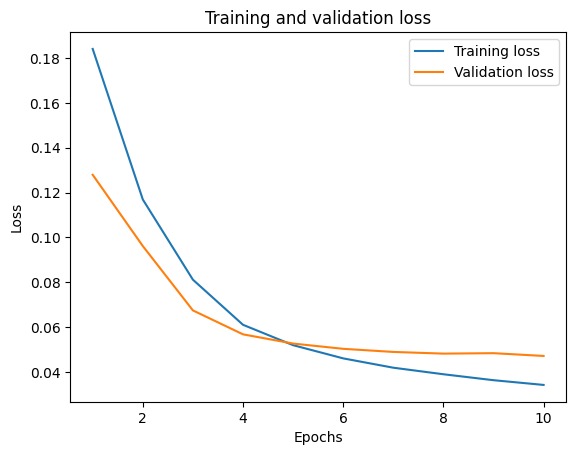

In [103]:
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

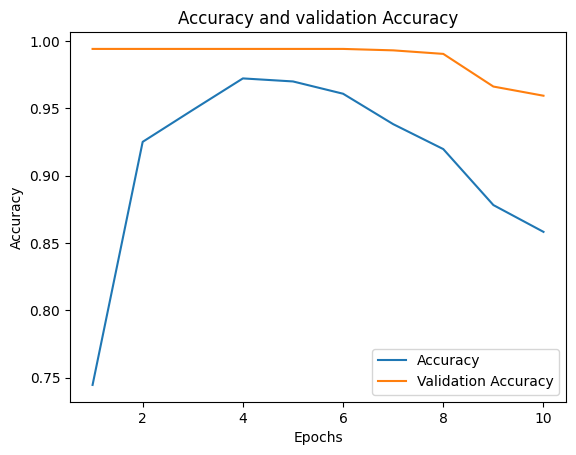

In [104]:
loss = history_0.history['accuracy']
val_loss = history_0.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [93]:
pred=lstm_0.predict(test_padded_X)

In [73]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_length))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1356, 128)         6144000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 6,195,686
Trainable params: 6,195,686
No

In [74]:
history = model.fit(train_padded_X, train_Y,
          batch_size=128,
          epochs=10,
          validation_data= [val_padded_X,val_Y])

Epoch 1/10
 12/375 [..............................] - ETA: 6:52 - loss: 0.6044 - accuracy: 0.1113

KeyboardInterrupt: 